In [44]:
import os
import glob
import tqdm
import scipy
import numpy as np
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt

In [2]:
sessions = pd.read_csv('../sessions/final_lang_atlas_sessions.csv');
coverage = pd.read_csv('../coverage/LanA_cerebellar_coverage.csv');
# n=3 with only 1 data file, n=49 missing>=50 cerebellar parcels
sessions = sessions.loc[(sessions.Runs>=2) & (coverage.CerebellumVoxelsMissing<50),:] # n=754

In [3]:
sessions.head()

,UID,Age,Gender,ScanDate,Session,Experiment,Runs
0,1,37.0,F,2007-09-07,001_SWJN_01_PL2017,SWJN,8
1,2,33.0,M,2007-10-01,002_SWJN_05_PL2017,SWJN,8
2,3,37.0,F,2007-10-20,003_SWJN_07_PL2017,SWJN,8
3,4,32.0,F,2007-10-20,004_SWJN_09_PL2017,SWJN,8
4,5,34.0,F,2007-10-21,005_SWJN_11_PL2017,SWJN,8


In [41]:
SUBJECTS_DIR = '/mindhive/evlab/u/Shared/SUBJECTS'

# parcels
parcels_cereb = nb.load('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/fROIs_cerebellum_only_symmetrical.nii').get_fdata().flatten()
labels_cereb = pd.read_csv('../LanA_GSS_SN_reduced_subjects_percentile-whole-brain_0.1_0.1/labels_cerebellum_only_symmetrical.txt', header=None)[0].tolist()
parcels_cortex = nb.load('/mindhive/evlab/u/Shared/ROIS_Nov2020/Func_Lang_LHRH_SN220/allParcels_language.nii').get_fdata().flatten()
parcels_cortex = [voxel in [1,2,3,4,5] for voxel in parcels_cortex]

# effect size estimates 
effectsizes_cereb = pd.read_csv('../../experiments/langloc/mROI_0.1_langLOC_langEFFECT_symmetrical_GSS_percentile-whole-brain_0.1_0.1/spm_ss_mROI_data.csv')
effectsizes_cereb = effectsizes_cereb.loc[(effectsizes_cereb.Effect=='S')]
effectsizes_cortex = pd.read_csv('../../experiments/langloc/mROI_0.1_langLOC_langEFFECT_language_standard/spm_ss_mROI_data.csv')
effectsizes_cortex = effectsizes_cortex.loc[[roi in [1,2,3,4,5] for roi in effectsizes_cortex.ROI] & (effectsizes_cortex.Effect=='S')]
effectsizes_cortex = effectsizes_cortex.groupby('Subject')['EffectSize'].mean()

# extract signal quality (residual sum-of-squares)
signal_quality = pd.DataFrame([],index=sessions.Session, columns=['LH_Language', *labels_cereb])
with tqdm.tqdm(total=sessions.shape[0]) as pbar:
    for idx, row in sessions.iterrows():
        new_row = [] 
        vol_ResMS = nb.load(os.path.join(SUBJECTS_DIR,row.Session,'firstlevel_'+row.Experiment,'ResMS.nii')).get_fdata().flatten()
        
        # --- NEOCORTEX ---
        files = pd.read_csv('../../experiments/langloc/mROI_0.1_langLOC_langEFFECT_language_standard/spm_ss_mROI_data.details.SourceFiles.csv')
        file1 = files.loc[(files['Session/Partition']==1) & (files['Subject']==row.Session)].Localizer.values[0]
        mask_cortex1 = nb.load(file1).get_fdata().flatten()
        mask_cortex1 = np.logical_and(mask_cortex1, parcels_cortex)
        file2 = files.loc[(files['Session/Partition']==2) & (files['Subject']==row.Session)].Localizer.values[0]
        mask_cortex2 = nb.load(file2).get_fdata().flatten()
        mask_cortex2 = np.logical_and(mask_cortex2, parcels_cortex)
        rss = np.nanmean([np.nanmean(vol_ResMS[mask_cortex1]),np.nanmean(vol_ResMS[mask_cortex2])])
        new_row.append(effectsizes_cortex.loc[row.Session]/rss)
    
        # --- CEREBELLUM ---
        files = pd.read_csv('../../experiments/langloc/mROI_0.1_langLOC_langEFFECT_symmetrical_GSS_percentile-whole-brain_0.1_0.1/spm_ss_mROI_data.details.SourceFiles.csv')
        file1 = files.loc[(files['Session/Partition']==1) & (files['Subject']==row.Session)].Localizer.values[0]
        mask_cereb1 = nb.load(file1).get_fdata().flatten()
        file2 = files.loc[(files['Session/Partition']==2) & (files['Subject']==row.Session)].Localizer.values[0]
        mask_cereb2 = nb.load(file2).get_fdata().flatten()
        for l, label in enumerate(labels_cereb):
            mask_cereb_curr1 = np.logical_and(mask_cereb1, parcels_cereb==(l+1))
            mask_cereb_curr2 = np.logical_and(mask_cereb2, parcels_cereb==(l+1))
            rss = np.nanmean([np.nanmean(vol_ResMS[mask_cereb_curr1]),np.nanmean(vol_ResMS[mask_cereb_curr2])])
            new_row.append(effectsizes_cereb.loc[(effectsizes_cereb.Subject==row.Session) & (effectsizes_cereb.ROI==(l+1))]['EffectSize'].values[0]/rss)
    
        signal_quality.loc[row.Session,:] = new_row
        pbar.update(1)

signal_quality.to_csv('signal_quality_averagedODDEVEN.csv')

 31%|████████████████████████████████████████████████████████                                                                                                                               | 231/754 [03:17<07:04,  1.23it/s]/tmp/ipykernel_3722787/3579188612.py:43: RuntimeWarning: Mean of empty slice
  rss = np.nanmean([np.nanmean(vol_ResMS[mask_cereb_curr1]),np.nanmean(vol_ResMS[mask_cereb_curr2])])
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 741/754 [08:40<00:08,  1.51it/s]/tmp/ipykernel_3722787/3579188612.py:43: RuntimeWarning: Mean of empty slice
  rss = np.nanmean([np.nanmean(vol_ResMS[mask_cereb_curr1]),np.nanmean(vol_ResMS[mask_cereb_curr2])])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 

In [29]:
signal_quality.head()

,LH_Language,Right_CrusII_VIIb,Right_CrusI_Dentate,Right_VIIIa,Right_CrusI,Left_CrusII_VIIb,Left_CrusI_Dentate,Left_VIIIa,Left_CrusI
Session,,,,,,,,,
001_SWJN_01_PL2017,0.544111,0.225744,0.35718,0.449993,0.307953,-0.021574,0.055198,0.080455,0.301271
002_SWJN_05_PL2017,0.188235,0.166158,0.107438,0.217753,0.258788,-0.110667,-0.119391,0.069339,0.16372
003_SWJN_07_PL2017,0.369607,0.293566,0.227248,0.406794,0.589104,0.076465,-0.025038,0.173394,0.007149
004_SWJN_09_PL2017,0.696608,0.670628,0.400863,0.301295,0.128139,0.540638,0.342788,0.30549,0.376634
005_SWJN_11_PL2017,0.29132,0.186797,0.092164,0.174294,0.23321,0.045619,0.097663,0.008582,0.559175


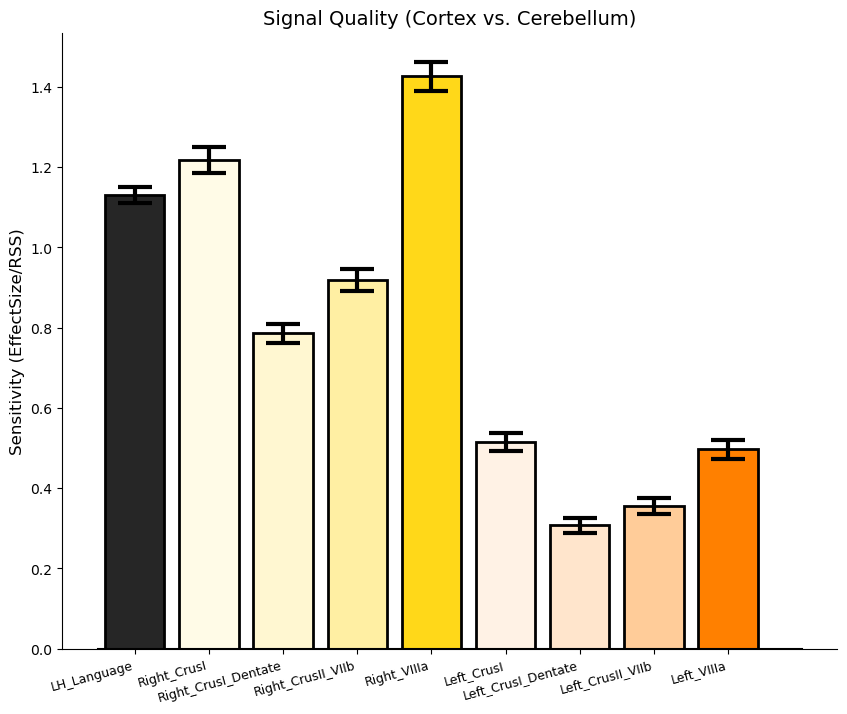

In [42]:
# plot results
signal = pd.read_csv('signal_quality_averagedODDEVEN.csv', index_col=0)
colors = [
    (0.15, 0.15, 0.15, 1),
    (1.0, 0.8470588235294118, 0.09803921568627451, 0.4),
    (1.0, 0.8470588235294118, 0.09803921568627451, 0.2),
    (1.0, 0.8470588235294118, 0.09803921568627451, 1.0),
    (1.0, 0.8470588235294118, 0.09803921568627451, 0.1),
    (1.0, 0.5019607843137255, 0.0, 0.4),
    (1.0, 0.5019607843137255, 0.0, 0.2),
    (1.0, 0.5019607843137255, 0.0, 1.0),
    (1.0, 0.5019607843137255, 0.0, 0.1)
]

plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
plt.rc('font',**{'family':'sans-serif'})
plt.rc('pdf', **{'fonttype':42})
fig, ax = plt.subplots(figsize=(10,8),visible=True)
sliding_x = 1

for r in [0,4,2,1,3,8,6,5,7]: # reorder ROIs so matches paper
    roi = signal.columns[r]
    color = colors[r]

    vals = signal[roi]
    plt.bar(x=sliding_x,
            height=np.nanmean(vals,axis=0),
            yerr=np.nanstd(vals,axis=0)/np.sqrt(len(vals)),
            edgecolor='k',
            linewidth=2,
            color=color,
            capsize=12,
            error_kw={'elinewidth' : 3, 'capthick' : 3}
    ) 
    # plt.scatter(np.ones((len(vals),1))*sliding_x,
    #             vals,
    #             s=np.array([60]*len(vals)),
    #             c=[color]*len(vals),
    #             edgecolors='k',
    #             alpha=0.7
    # )
    sliding_x = sliding_x+1
                

ax.set_xticks(np.arange(1,signal.shape[1]+1))
ax.set_xticklabels([signal.columns[i] for i in [0,4,2,1,3,8,6,5,7]], fontsize=9, ha='right', rotation=15)
ax.set_ylabel('Sensitivity (EffectSize/RSS)', fontsize=12)
ax.set_title('Signal Quality (Cortex vs. Cerebellum)', fontsize=14)
plt.plot([0.5, sliding_x],[0, 0],'k')

plt.savefig('signal_quality_averagedODDEVEN.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5)

In [51]:
# testing significance 
signal = pd.read_csv('signal_quality_averagedODDEVEN.csv', index_col=0)
for r in [4,2,1,3,8,6,5,7]: # reorder ROIs so matches paper
    cortex = signal[signal.columns[0]].values
    roi = signal[signal.columns[r]].values
    cortex = cortex[~np.isnan(roi)]
    roi = roi[~np.isnan(roi)]
    result = scipy.stats.wilcoxon(cortex, roi)
    print(f'{signal.columns[r]} vs. neocortex mean_cortex={np.mean(cortex):.05f} mean_cereb={np.mean(roi):.05f} p={result.pvalue:.05f} (n={len(roi)} subjects)')

Right_CrusI vs. neocortex mean_cortex=1.13052 mean_cereb=1.21764 p=0.00400 (n=754 subjects)
Right_CrusI_Dentate vs. neocortex mean_cortex=1.13052 mean_cereb=0.78539 p=0.00000 (n=754 subjects)
Right_CrusII_VIIb vs. neocortex mean_cortex=1.13052 mean_cereb=0.91882 p=0.00000 (n=754 subjects)
Right_VIIIa vs. neocortex mean_cortex=1.13283 mean_cereb=1.42625 p=0.00000 (n=752 subjects)
Left_CrusI vs. neocortex mean_cortex=1.13052 mean_cereb=0.51516 p=0.00000 (n=754 subjects)
Left_CrusI_Dentate vs. neocortex mean_cortex=1.13052 mean_cereb=0.30749 p=0.00000 (n=754 subjects)
Left_CrusII_VIIb vs. neocortex mean_cortex=1.13052 mean_cereb=0.35464 p=0.00000 (n=754 subjects)
Left_VIIIa vs. neocortex mean_cortex=1.13152 mean_cereb=0.49664 p=0.00000 (n=753 subjects)
